In [1]:
import main
from pyspark import SparkContext

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
sc = SparkContext("local", "Influence_Maximization")

In [4]:
NC_digraph = main.import_graph("nc_mini.json")

In [8]:
nodesRDD = sc.parallelize(NC_digraph.nodes(),4)
nodesRDD.take(5)

[u'PpkKVodWC0sdn74TbHQLzA',
 u'9kNIqxBAFKkPVIN_7MRtOg',
 u'lhIEvJs8o09n6-zdffln0g',
 u'GrA3BLjRjAKvFYwSqN_4cg',
 u'_-S38fYbXdf2J9n7se30jg']

In [12]:
pairsRDD = nodesRDD.map(lambda x: (set([x]),main.cascade_trials(1000,[x],NC_digraph)['mean']))

In [15]:
pairsRDD.takeOrdered(10, key=lambda x: -x[1])

[({u'NzWLMPvbEval0OVg_YDn4g'}, 28.629000000000001),
 ({u'ts7EG6Zv2zdMDg29nyqGfA'}, 27.666),
 ({u'VhI6xyylcAxi0wOy2HOX3w'}, 26.916),
 ({u'-_1ctLaz3jhPYc12hKXsEQ'}, 25.712),
 ({u'lpZtfD-vCqUER1yGKEvUPw'}, 25.648),
 ({u's9I4KMcrHKki44g_eTrYqQ'}, 23.577999999999999),
 ({u'LP0bl3GKToABt3lnpSvA2w'}, 23.471),
 ({u'M-TwsqjrGVH9-qyw2KcvdQ'}, 22.873000000000001),
 ({u'A6bPFcUjuuayRBoyybedDQ'}, 21.824000000000002),
 ({u'3GteArKIVRlJZjjRqqwgaQ'}, 21.550999999999998)]

In [7]:
main.greedy_max_influence(NC_digraph,1,100)

{u'NzWLMPvbEval0OVg_YDn4g'}

In [9]:
def spark_greedy_max_influence(graph_rdd, graph, select_count, trials, iterations=float("inf"), numPartitions=4):
    max_influence = (set(), 0)
    for iteration in range(1, select_count+1):
        pairsRDD = graph_rdd.map(lambda x: (max_influence[0] | set([x]), main.cascade_trials(trials, max_influence[0] | set([x]), graph, iterations)['mean']))
        pairsRDD = pairsRDD.filter(lambda x: len(x[0]) == iteration)
        max_influence = pairsRDD.takeOrdered(1, key=lambda x: -x[1])[0]
    return max_influence

In [10]:
spark_greedy_max_influence(nodesRDD, NC_digraph, 3, 1000)

({u'-_1ctLaz3jhPYc12hKXsEQ',
  u'NzWLMPvbEval0OVg_YDn4g',
  u'VhI6xyylcAxi0wOy2HOX3w'},
 46.959000000000003)

In [17]:
def spark_greedy_trials(num_trials, g, k, N, t=float("inf"), partitions=4):
    results = []
    nodes = []
    grdd = sc.parallelize(g.nodes(), partitions)
    for trial in range(0, num_trials):
        result = spark_greedy_max_influence(grdd, g, k, N, t, partitions)
        results.append(result[1])
        nodes.append(result[0])
    return {"nodes": nodes, "results": results}
    

In [ ]:
problem_2a = spark_greedy_trials(100, NC_digraph, 3, 1000, 10)

In [19]:
_lambda = min(problem_2a["results"])/max(problem_2a["results"])
print _lambda

0.778501628664


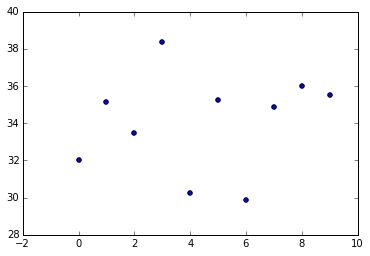

In [20]:
#scatter
plt.scatter(range(0, len(problem_2a["results"])),problem_2a["results"])

([<matplotlib.patches.Wedge at 0x10bfc4350>,
  <matplotlib.text.Text at 0x10bff5350>])

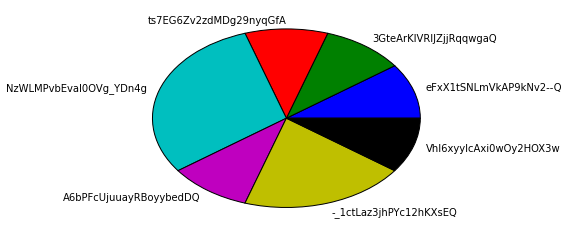

In [27]:
#dictionary of node -> times in max
node_count = {}
for result in problem_2a["nodes"]:
    for node in result:
        if node not in node_count:
            node_count[node] = 1
        else:
            node_count[node] += 1
plt.pie(node_count.values(), labels=node_count.keys())